In [40]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.utils import save_image
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [41]:
batch_size = 64
learning_rate = 0.0002
num_epochs = 50
latent_dim = 100  # 생성자를 위한 랜덤 노이즈 벡터의 크기
img_shape = (1, 28, 28)  # MNIST 이미지의 모양


In [42]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

mnist_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

dataloader = DataLoader(dataset=mnist_data, batch_size=batch_size, shuffle=True)

for images, labels in dataloader:
    print(images.shape)  # (배치 크기, 채널 수, 높이, 너비)
    print(labels.shape)  # (배치 크기)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


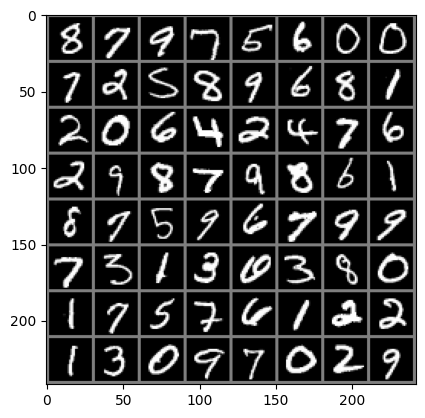

In [43]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [44]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


label 0: 생성된 이미지

label 1: 실제 이미지

In [45]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = 7
        self.fc = nn.Linear(latent_dim, 128 * self.init_size * self.init_size)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


In [46]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(512, 1, kernel_size=2, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity.view(validity.size(0), -1)


In [47]:
generator = Generator()
discriminator = Discriminator()

adversarial_loss = nn.BCELoss()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
def show_generated_imgs(generator, latent_dim, num_images=5):
    z = torch.randn(num_images, latent_dim).to(device)
    gen_imgs = generator(z)
    gen_imgs = gen_imgs.view(gen_imgs.size(0), 1, 28, 28)
    gen_imgs = gen_imgs.detach().cpu().numpy()

    fig, axes = plt.subplots(1, num_images, figsize=(num_images, 1))
    for i in range(num_images):
        axes[i].imshow(np.transpose(gen_imgs[i], (1, 2, 0)).squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.show()

In [49]:
generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짠지 가짠지에 대한 레이블 생성
        valid = torch.ones((imgs.size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((imgs.size(0), 1), requires_grad=False).to(device)

        # 진짜 이미지 (데이터셋에서 불러온거)
        real_imgs = imgs.to(device)

        ### 생성기 학습
        optimizer_G.zero_grad()

        # 랜덤 노이즈로부터 이미지 생성
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        gen_imgs = generator(z)

        # 생성된 이미지를 판별자에 넣어서 결과 확인
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()


        ### 판별기 학습
        optimizer_D.zero_grad()

        # 진짜 이미지 판별
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if i % 400 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)} \
                  Loss D: {d_loss.item()}, loss G: {g_loss.item()}")

    # 중간 단계 확인을 위해 생성된 이미지 저장
    if epoch % 2 == 0:
        #gen_imgs = gen_imgs.view(gen_imgs.size(0), 1, 28, 28)
        save_image(gen_imgs.data[:25], f"/content/drive/My Drive/Colab Notebooks/HAI/방학 과제/images/{epoch}.png", nrow=5, normalize=True)


Epoch [0/50] Batch 0/938                   Loss D: 0.7435633540153503, loss G: 0.7065815925598145
Epoch [0/50] Batch 400/938                   Loss D: 0.3527819514274597, loss G: 3.083320379257202
Epoch [0/50] Batch 800/938                   Loss D: 0.37345242500305176, loss G: 2.754566192626953
Epoch [1/50] Batch 0/938                   Loss D: 0.16069090366363525, loss G: 2.4410412311553955
Epoch [1/50] Batch 400/938                   Loss D: 0.24132521450519562, loss G: 2.1438074111938477
Epoch [1/50] Batch 800/938                   Loss D: 0.35648638010025024, loss G: 1.032498836517334
Epoch [2/50] Batch 0/938                   Loss D: 0.5710634589195251, loss G: 0.9113976955413818
Epoch [2/50] Batch 400/938                   Loss D: 0.13929429650306702, loss G: 1.6349844932556152
Epoch [2/50] Batch 800/938                   Loss D: 0.1258188784122467, loss G: 2.751368999481201
Epoch [3/50] Batch 0/938                   Loss D: 0.07558181881904602, loss G: 2.7209668159484863
Epoch 

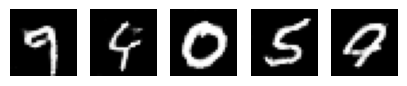

In [52]:
show_generated_imgs(generator, latent_dim)

In [53]:
gen_path = '/content/drive/My Drive/Colab Notebooks/HAI/방학 과제/generator.pth'
dis_path = '/content/drive/My Drive/Colab Notebooks/HAI/방학 과제/discriminator.pth'
torch.save(generator.state_dict(), gen_path)
torch.save(discriminator.state_dict(), dis_path)